In [1]:
from __future__ import print_function
%matplotlib inline

from sklearn.model_selection import train_test_split,GridSearchCV
import pandas as pd
import numpy as np
from collections import Counter
from PIL import Image as PImage
from os import listdir
from pickle import dump
import matplotlib.pyplot as plt
import PIL, cv2, os, json


import keras, h5py
import tensorflow as tf
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K
from keras.utils import to_categorical
from keras.backend.tensorflow_backend import set_session
from keras.callbacks import TensorBoard

Using TensorFlow backend.


### Set TF config 

 - mainly used to restrict memory usage

In [2]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
set_session(tf.Session(config=config))

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9693956880072670425
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5695799296
locality {
  bus_id: 1
}
incarnation: 18126924544315920292
physical_device_desc: "device: 0, name: TITAN Xp, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


## Image Training Data

In [4]:
!ls ../../aiacademy-learning-notebook/Midterm_Image/train/CALsuburb/

image_0001.jpg	image_0030.jpg	image_0059.jpg	image_0088.jpg	image_0117.jpg
image_0002.jpg	image_0031.jpg	image_0060.jpg	image_0089.jpg	image_0118.jpg
image_0003.jpg	image_0032.jpg	image_0061.jpg	image_0090.jpg	image_0119.jpg
image_0004.jpg	image_0033.jpg	image_0062.jpg	image_0091.jpg	image_0120.jpg
image_0005.jpg	image_0034.jpg	image_0063.jpg	image_0092.jpg	image_0121.jpg
image_0006.jpg	image_0035.jpg	image_0064.jpg	image_0093.jpg	image_0122.jpg
image_0007.jpg	image_0036.jpg	image_0065.jpg	image_0094.jpg	image_0123.jpg
image_0008.jpg	image_0037.jpg	image_0066.jpg	image_0095.jpg	image_0124.jpg
image_0009.jpg	image_0038.jpg	image_0067.jpg	image_0096.jpg	image_0125.jpg
image_0010.jpg	image_0039.jpg	image_0068.jpg	image_0097.jpg	image_0126.jpg
image_0011.jpg	image_0040.jpg	image_0069.jpg	image_0098.jpg	image_0127.jpg
image_0012.jpg	image_0041.jpg	image_0070.jpg	image_0099.jpg	image_0128.jpg
image_0013.jpg	image_0042.jpg	image_0071.jpg	image_0100.jpg	image_0129.jpg
image_0014.jpg	image_0043

In [5]:
train_dir = '../../aiacademy-learning-notebook/Midterm_Image'

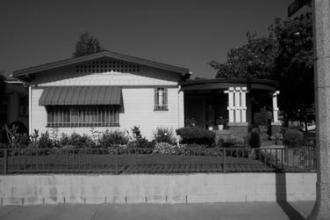

In [6]:
from IPython.display import Image
Image(os.path.join(train_dir, 'train/CALsuburb/image_0001.jpg'))

In [7]:
df = pd.read_csv("../../aiacademy-learning-notebook/Midterm_Image/mapping.csv",header=None)

In [8]:
m = dict()
for cate,i in zip(df[0],df[1]):
    m[cate] = i
m

{'CALsuburb': 9,
 'PARoffice': 7,
 'bedroom': 12,
 'coast': 10,
 'forest': 4,
 'highway': 14,
 'industrial': 2,
 'insidecity': 3,
 'kitchen': 0,
 'livingroom': 5,
 'mountain': 8,
 'opencountry': 6,
 'store': 11,
 'street': 1,
 'tallbuilding': 13}

### manipulate image

In [9]:
from imgaug import augmenters as iaa
import imgaug as ia

seq = iaa.Sequential([
                    iaa.Fliplr(0.5),               # 左右翻轉
                    iaa.Flipud(0.5),               # 上下翻轉
                    iaa.Affine(rotate=(-90, 90),   # 旋轉
                    scale=(0.6, 1.4),              # 縮放
                    mode = 'edge',                 # 影像翻轉造成區塊缺值的補值方式
                    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)})]) # 平移
#img = seq.augment_image(img)

### Prepare training data

In [10]:
label =[]
images_flist = []
import os
for cate in m.keys():
    dc = os.path.join(train_dir, "train/" + cate + "/") 
    for fname in os.listdir(dc):
        fpath = dc + fname
        label.append(m[cate])
        images_flist.append(fpath)

X_imgf_train, X_imgf_test, y_train, y_test = train_test_split(images_flist, label, test_size=0.1, random_state=100)

In [11]:
total_images = len(label)
lc = Counter(label)

### Read and resize image

In [12]:
def readImg(flist, labels, is_aug=False):
    images = []
    r_lable = []
    for fname,label in zip(flist,labels):
        img = cv2.imread(fname)
        img = cv2.resize(img, (224, 224))
        
        images.append(img) 
        r_lable.append(label)     
        
        if is_aug==True:
            for _ in range( int(0.3*total_images/lc[label] )  ):

                resized_image = seq.augment_image(img)
                images.append(resized_image) 
                r_lable.append(label)

    return (images,r_lable)

In [13]:
X_train, y_train  = readImg(X_imgf_train, y_train, is_aug=True)

### Show all label count

In [14]:
Counter(y_train)

Counter({0: 882,
         1: 850,
         2: 950,
         3: 935,
         4: 816,
         5: 875,
         6: 834,
         7: 808,
         8: 984,
         9: 896,
         10: 924,
         11: 990,
         12: 800,
         13: 952,
         14: 852})

In [15]:
X_train[0].shape

(224, 224, 3)

In [16]:
from keras.applications.vgg16 import preprocess_input
X_train = np.array(X_train)

In [17]:
X_train[0]

array([[[100, 100, 100],
        [101, 101, 101],
        [112, 112, 112],
        ..., 
        [ 78,  78,  78],
        [ 93,  93,  93],
        [ 67,  67,  67]],

       [[158, 158, 158],
        [177, 177, 177],
        [154, 154, 154],
        ..., 
        [101, 101, 101],
        [125, 125, 125],
        [108, 108, 108]],

       [[170, 170, 170],
        [223, 223, 223],
        [199, 199, 199],
        ..., 
        [100, 100, 100],
        [122, 122, 122],
        [106, 106, 106]],

       ..., 
       [[ 63,  63,  63],
        [ 75,  75,  75],
        [ 74,  74,  74],
        ..., 
        [ 93,  93,  93],
        [ 93,  93,  93],
        [ 73,  73,  73]],

       [[ 61,  61,  61],
        [ 74,  74,  74],
        [ 73,  73,  73],
        ..., 
        [ 98,  98,  98],
        [100, 100, 100],
        [ 83,  83,  83]],

       [[ 51,  51,  51],
        [ 63,  63,  63],
        [ 62,  62,  62],
        ..., 
        [ 69,  69,  69],
        [ 74,  74,  74],
        [ 57,  57,

In [18]:
X_train = preprocess_input(X_train.astype(np.float32))

In [19]:
X_train[0]

array([[[  -3.93900299,  -16.77899933,  -23.68000031],
        [  -2.93900299,  -15.77899933,  -22.68000031],
        [   8.06099701,   -4.77899933,  -11.68000031],
        ..., 
        [ -25.93900299,  -38.77899933,  -45.68000031],
        [ -10.93900299,  -23.77899933,  -30.68000031],
        [ -36.93900299,  -49.77899933,  -56.68000031]],

       [[  54.06099701,   41.22100067,   34.31999969],
        [  73.06099701,   60.22100067,   53.31999969],
        [  50.06099701,   37.22100067,   30.31999969],
        ..., 
        [  -2.93900299,  -15.77899933,  -22.68000031],
        [  21.06099701,    8.22100067,    1.31999969],
        [   4.06099701,   -8.77899933,  -15.68000031]],

       [[  66.06099701,   53.22100067,   46.31999969],
        [ 119.06099701,  106.22100067,   99.31999969],
        [  95.06099701,   82.22100067,   75.31999969],
        ..., 
        [  -3.93900299,  -16.77899933,  -23.68000031],
        [  18.06099701,    5.22100067,   -1.68000031],
        [   2.06099

In [20]:
X_train.shape

(13348, 224, 224, 3)

In [21]:
X_train[0].shape

(224, 224, 3)

In [22]:
y_train = to_categorical(y_train)

In [23]:
X_test,y_test  = readImg(X_imgf_test,y_test,is_aug=False)

In [24]:
X_test = np.array(X_test)
X_test = preprocess_input(X_test.astype(np.float32))

In [25]:
y_test = to_categorical(y_test)

### Start To Load Model

In [26]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model

In [27]:
# load the model
base_model = VGG16()
# re-structure the model
base_model.layers.pop()
model = Model(inputs=base_model.inputs, outputs=[base_model.layers[-1].output])
# summarize
print(model.summary())
# extract features from each photo

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [28]:
X_train_new = model.predict(X_train, verbose=0)
X_train_new.dump("./X_train_new.pk")

In [29]:
X_test_new = model.predict(X_test, verbose=0)

In [30]:
X_test_new.shape

(299, 4096)

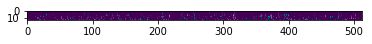

In [52]:
# plt.imshow(X_test_new[0][3])

In [31]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten
from keras.layers import Conv2D,Dropout,BatchNormalization
from keras import regularizers

### Transfer Learning Flow

In [32]:
newInput = Input(shape=[4096])
drop1 = Dropout(0.05)(newInput)
d1 = Dense(1024,activation='relu',kernel_regularizer=regularizers.l1(0.0003))(drop1)
# drop2 = Dropout(0.1)(d1)
b1= BatchNormalization()(d1)
d2 = Dense(64,activation='relu', kernel_regularizer=regularizers.l2(0.0003))(b1)
output = Dense(15,activation='softmax')(d2)
model_new = Model(inputs=[newInput], outputs=[output])
model_new.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 4096)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              4195328   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                65600     
_________________________________________________________________
dense_3 (Dense)              (None, 15)                975       
Total params: 4,265,999
Trainable params: 4,263,951
Non-trainable params: 2,048
______________________________________________________________

In [33]:
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
model_new.compile(optimizer=Adam(),
              loss=categorical_crossentropy, metrics=['acc',])

In [35]:
model_new.fit(x = [X_train_new],
              y = [y_train] ,
              validation_data = [X_test_new, y_test],
              epochs = 20,
              shuffle = True)

Train on 13348 samples, validate on 299 samples
Epoch 1/20
13348/13348 [==============================] - 3s 220us/step - loss: 3.0828 - acc: 0.7177 - val_loss: 2.9178 - val_acc: 0.7358
Epoch 2/20
13348/13348 [==============================] - 3s 207us/step - loss: 2.8130 - acc: 0.7255 - val_loss: 2.3448 - val_acc: 0.8227
Epoch 3/20
13348/13348 [==============================] - 3s 240us/step - loss: 2.6509 - acc: 0.7377 - val_loss: 2.3779 - val_acc: 0.8094
Epoch 4/20
13348/13348 [==============================] - 3s 225us/step - loss: 2.4155 - acc: 0.7566 - val_loss: 2.1581 - val_acc: 0.8060
Epoch 5/20
13348/13348 [==============================] - 3s 219us/step - loss: 2.3334 - acc: 0.7667 - val_loss: 2.1521 - val_acc: 0.7926
Epoch 6/20
13348/13348 [==============================] - 3s 216us/step - loss: 2.1741 - acc: 0.7768 - val_loss: 2.0673 - val_acc: 0.8261
Epoch 7/20
13348/13348 [==============================] - 3s 238us/step - loss: 2.0551 - acc: 0.7899 - val_loss: 2.2139 - va

In [36]:
model_new.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 4096)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              4195328   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                65600     
_________________________________________________________________
dense_3 (Dense)              (None, 15)                975       
Total params: 4,265,999
Trainable params: 4,263,951
Non-trainable params: 2,048
______________________________________________________________

In [37]:
model_new.save('../model/VGG16_transfer_15.h5')

In [57]:
#http://yenlung-blog.logdown.com/posts/864703-deep-learning-keras-vgg19
#block4_pool_features = model.predict(x)
#plt.imshow(block4_pool_features[0][3])